# Comparison Fortran Codes APIs on GPU Environment

In [1]:
!pgfortran --version


pgfortran (aka nvfortran) 23.11-0 64-bit target on Linux -tp skylake-avx512 
PGI Compilers and Tools
Copyright (c) 2023, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

pgfortran (aka nvfortran) 23.11-0 64-bit target on x86-64 Linux -tp skylake-avx512 
PGI Compilers and Tools
Copyright (c) 2023, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.


In [2]:
!nvfortran --version


nvfortran 23.11-0 64-bit target on x86-64 Linux -tp skylake-avx512 
NVIDIA Compilers and Tools
Copyright (c) 2023, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.


## Environment Modules on AIRIS

These modules must be initialized before running the jupyter-notebook:
```cpp
Currently Loaded Modulefiles:
    1) anaconda3/2023.07     
    2) ucx/1.15.0
    3) openmpi/4.1.5  
    4) nvhpc/23.11
    5) llvm/12.0.0
```

In [ ]:
#!module load anaconda3/2023.07 ucx/1.15.0 openmpi/4.1.5 nvhpc/23.11 llvm/12.0.0

## `Matrix Multiple Benchmarks `

### ⊗ Sequential

In [5]:
%%writefile mm-sequential.f90
program matrix_multiply_sequential
 implicit none

 integer :: n, i, j, k
 real, allocatable :: A(:,:), B(:,:), C(:,:)
 character(len=100) :: arg
    
 integer :: start_count, end_count, rate, count_max
 real :: elapsed_time  

 ! Get the command-line argument for the matrix size
 call get_command_argument(1, arg)
 read(arg, *) n

 ! Allocate matrices
 allocate(A(n, n))
 allocate(B(n, n))
 allocate(C(n, n))

 ! Initialize matrices A and B
 call random_number(A)
 call random_number(B)
 C = 0.0

 ! Get the clock rate (ticks per second) and the maximum count value
 call system_clock(count_max=count_max, count_rate=rate)

 ! Get the start time
 call system_clock(start_count)

 do i = 1, n
    do j = 1, n
       do k = 1, n
          C(i, j) = C(i, j) + A(i, k) * B(k, j)
       end do
    end do
 end do

 ! Get the end time
 call system_clock(end_count)

 ! Calculate the elapsed time in seconds
 elapsed_time = real(end_count - start_count) / rate

 ! Print the elapsed time
 print '(I0, "  ", F0.2)', n, elapsed_time

 ! Deallocate matrices
 deallocate(A)
 deallocate(B)
 deallocate(C)
  
end program matrix_multiply_sequential

Writing mm-sequential.f90


In [6]:
!nvfortran mm-sequential.f90 -o mm-sequential

In [7]:
!./mm-sequential 1000

1000  3.04


### ⊗ OpenMP

In [14]:
%%writefile mm-omp.f90
program matrix_multiply_openmp
 use omp_lib
 implicit none

 integer :: n, i, j, k
 real, allocatable :: A(:,:), B(:,:), C(:,:)
 character(len=100) :: arg
    
 integer :: start_count, end_count, rate, count_max
 real :: elapsed_time  

 ! Get the command-line argument for the matrix size
 call get_command_argument(1, arg)
 read(arg, *) n

 ! Allocate matrices
 allocate(A(n, n))
 allocate(B(n, n))
 allocate(C(n, n))

 ! Initialize matrices A and B
 call random_number(A)
 call random_number(B)
 C = 0.0

 ! Get the clock rate (ticks per second) and the maximum count value
 call system_clock(count_max=count_max, count_rate=rate)

 ! Get the start time
 call system_clock(start_count)

!$omp parallel do private(i,j,k) shared(A,B,C)
 do i = 1, n
    do j = 1, n
       do k = 1, n
          C(i, j) = C(i, j) + A(i, k) * B(k, j)
       end do
    end do
 end do
!$omp end parallel do

 ! Get the end time
 call system_clock(end_count)

 ! Calculate the elapsed time in seconds
 elapsed_time = real(end_count - start_count) / rate

 ! Print the elapsed time
 print '(I0, "  ", F0.2)', n, elapsed_time

 ! Deallocate matrices
 deallocate(A)
 deallocate(B)
 deallocate(C)

end program matrix_multiply_openmp

Overwriting mm-omp.f90


In [15]:
!nvfortran mm-omp.f90 -o mm-omp -fopenmp -O3

In [16]:
!OMP_NUM_THREADS=32 ./mm-omp 1000

1000  0.05


### ⊗ OpenACC

In [17]:
%%writefile mm-openacc.f90
program matrix_multiply
  use openacc
  implicit none

  integer :: n, i, j, k
  real, allocatable :: A(:,:), B(:,:), C(:,:)
  character(len=100) :: arg
    
  integer :: start_count, end_count, rate, count_max
  real :: elapsed_time  

  ! Get the command-line argument for the matrix size
  call get_command_argument(1, arg)
  read(arg, *) n

  ! Allocate matrices
  allocate(A(n, n))
  allocate(B(n, n))
  allocate(C(n, n))

  ! Initialize matrices A and B
  call random_number(A)
  call random_number(B)
  C = 0.0

  ! Get the clock rate (ticks per second) and the maximum count value
  call system_clock(count_max=count_max, count_rate=rate)

  ! Get the start time
  call system_clock(start_count)

  ! Matrix multiplication using OpenACC
  !$acc data copyin(A, B), copyout(C)
  !$acc parallel loop collapse(2)
  do i = 1, n
     do j = 1, n
        do k = 1, n
           C(i, j) = C(i, j) + A(i, k) * B(k, j)
        end do
     end do
  end do
  !$acc end parallel loop
  !$acc end data

  ! Get the end time
  call system_clock(end_count)

  ! Calculate the elapsed time in seconds
  elapsed_time = real(end_count - start_count) / rate

  ! Print the elapsed time
  print '(I0, "  ", F0.2)', n, elapsed_time

  ! Deallocate matrices
  deallocate(A)
  deallocate(B)
  deallocate(C)

end program matrix_multiply

Writing mm-openacc.f90


In [30]:
!nvfortran mm-openacc.f90 -o mm-openacc -acc

In [31]:
!./mm-openacc 1000

1000  0.22


### ⊗ OpenMP5

In [23]:
%%writefile mm-omp5.f90
program matrix_multiply_openmp_offloading
  use omp_lib
  implicit none

  integer :: n, i, j, k
  real, allocatable :: A(:,:), B(:,:), C(:,:)
  character(len=100) :: arg
    
  integer :: start_count, end_count, rate, count_max
  real :: elapsed_time  

  ! Get the command-line argument for the matrix size
  call get_command_argument(1, arg)
  read(arg, *) n

  ! Allocate matrices
  allocate(A(n, n))
  allocate(B(n, n))
  allocate(C(n, n))

  ! Initialize matrices A and B
  call random_number(A)
  call random_number(B)
  C = 0.0

  ! Get the clock rate (ticks per second) and the maximum count value
  call system_clock(count_max=count_max, count_rate=rate)

  ! Get the start time
  call system_clock(start_count)

  ! Perform matrix multiplication using OpenMP 5.0 on GPU
  !$omp target data map(to: A(1:lda, 1:i), B(1:ldb, 1:j)) map(tofrom: C(1:ldc, 1:k))
  !$omp target teams distribute parallel for collapse(2) private(i,j,k) shared(A,B,C)
  do i = 1, n
     do j = 1, n
        do k = 1, n
           C(i, j) = C(i, j) + A(i, k) * B(k, j)
         end do
     end do
  end do
  !$omp end target teams distribute parallel for
  !$omp end target data

  ! Get the end time
  call system_clock(end_count)

  ! Calculate the elapsed time in seconds
  elapsed_time = real(end_count - start_count) / rate

  ! Print the elapsed time
  print '(I0, "  ", F0.2)', n, elapsed_time

  ! Deallocate matrices
  deallocate(A)
  deallocate(B)
  deallocate(C)

end program matrix_multiply_openmp_offloading

Writing mm-omp5.f90


In [26]:
!nvfortran mm-omp5.f90 -o mm-omp5 -stdpar=gpu -O3

In [27]:
!./mm-omp5 1000

1000  0.15


### Table with Comparison Performance Analysis using 1-GPU

#### AIRIS

| Program Version      | Execution Time (sec.)  | Speedup      |
| :---                 |    :----:              |        ---:  |
| Serial               | 0.16                   | 1X           |
| OpenMP T=36          | 0.05                   | 25X          |
| OpenACC              | 0.23                   | -            | 
| OpenMP5              | 0.15                   | -            | 

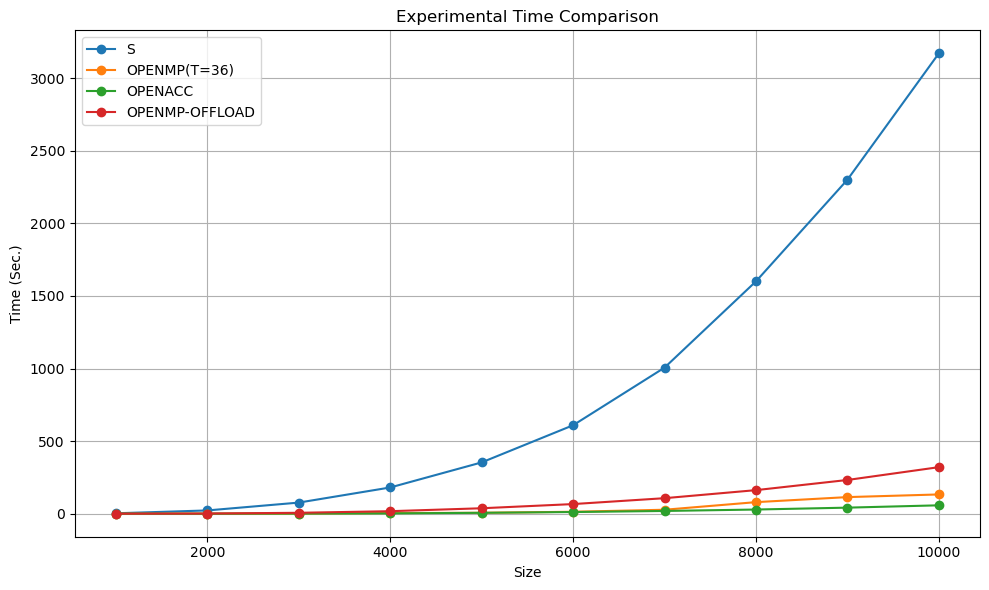

In [2]:
import matplotlib.pyplot as plt

# Data
sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
S = [3.02, 22.64, 76.68, 180.83, 353.48, 609.42, 1006.14, 1600.39, 2300.34, 3170.64]
OMP = [0.15, 0.29, 1.05, 4.62, 6.38, 13.52, 27.40, 79.75, 114.45, 132.80]
ACC = [0.22, 0.32, 1.11, 2.30, 6.32, 11.69, 19.02, 28.89, 41.87, 57.91]
OMP5 = [0.15, 1.29, 6.40, 17.44, 37.66, 66.48, 107.02, 162.46, 232.42, 320.67]

# Plot
plt.figure(figsize=(10, 6))

plt.plot(sizes, S, marker='o', label='S')
plt.plot(sizes, OMP, marker='o', label='OPENMP(T=36)')
plt.plot(sizes, ACC, marker='o', label='OPENACC')
plt.plot(sizes, OMP5, marker='o', label='OPENMP-OFFLOAD')

plt.xlabel('Size')
plt.ylabel('Time (Sec.)')
plt.title('Experimental Time Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


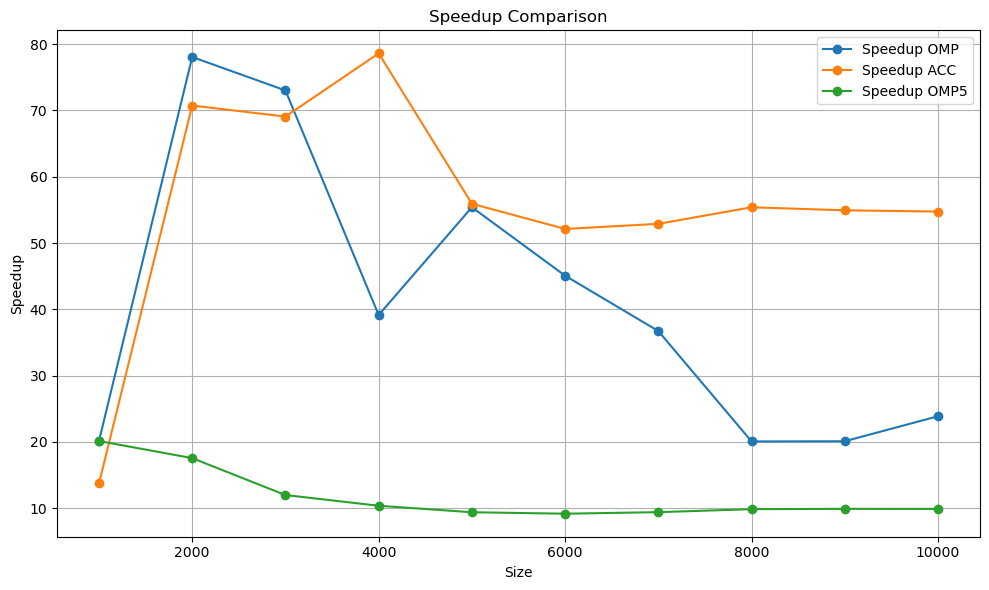

In [9]:
import matplotlib.pyplot as plt

# Data
sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
S = [3.02, 22.64, 76.68, 180.83, 353.48, 609.42, 1006.14, 1600.39, 2300.34, 3170.64]
OMP = [0.15, 0.29, 1.05, 4.62, 6.38, 13.52, 27.40, 79.75, 114.45, 132.80]
ACC = [0.22, 0.32, 1.11, 2.30, 6.32, 11.69, 19.02, 28.89, 41.87, 57.91]
OMP5 = [0.15, 1.29, 6.40, 17.44, 37.66, 66.48, 107.02, 162.46, 232.42, 320.67]

# Calculate Speedup
speedup_OMP = [s / omp for s, omp in zip(S, OMP)]
speedup_ACC = [s / acc for s, acc in zip(S, ACC)]
speedup_OMP5 = [s / omp5 for s, omp5 in zip(S, OMP5)]

# Plot
plt.figure(figsize=(10, 6))

plt.plot(sizes, speedup_OMP, marker='o', label='Speedup OMP')
plt.plot(sizes, speedup_ACC, marker='o', label='Speedup ACC')
plt.plot(sizes, speedup_OMP5, marker='o', label='Speedup OMP5')

plt.xlabel('Size')
plt.ylabel('Speedup')
plt.title('Speedup Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


## Limpando os arquivos remanescentes

In [8]:
!rm -rf mm* file* fspeed*